In [79]:
# Dependencies
%matplotlib inline

import csv
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import openweathermapy.core as owm
from citipy import citipy
from pprint import pprint
import json
import plotly

import tweepy

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

from datetime import datetime

from scipy.stats import sem, ttest_ind


In [2]:
lnd_temp = 'Resources/GlobalLandTemperaturesByState.csv'
wildfire = 'Resources/US_Fires_Over_One_Acre.csv'

lnd_temp_df = pd.read_csv(lnd_temp, low_memory=False)
wildfire_df = pd.read_csv(wildfire, low_memory=False)


lnd_temp_df.head()
#wildfire_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [3]:
temp_us_df = lnd_temp_df[lnd_temp_df['Country']=='United States']

In [4]:
temp_us_df['year'] = temp_us_df.dt.str.extract(r'([0-9][0-9][0-9][0-9])', expand=True)

C:\Users\aliqu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [5]:
# drop columns with NaN

temp_us_df = temp_us_df.dropna(subset = ['AverageTemperature', 'AverageTemperatureUncertainty'])
temp_us_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country,year
7458,1743-11-01,10.722,2.898,Alabama,United States,1743
7463,1744-04-01,19.075,2.902,Alabama,United States,1744
7464,1744-05-01,21.197,2.844,Alabama,United States,1744
7465,1744-06-01,25.290,2.879,Alabama,United States,1744
7466,1744-07-01,26.420,2.841,Alabama,United States,1744


In [6]:
#1992 - 2015

temp_us_df = temp_us_df[(temp_us_df['year'] >= '1992') & (temp_us_df['year'] <= '2015')]
temp_us_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country,year
10436,1992-01-01,6.979,0.218,Alabama,United States,1992
10437,1992-02-01,10.898,0.243,Alabama,United States,1992
10438,1992-03-01,12.995,0.197,Alabama,United States,1992
10439,1992-04-01,16.589,0.297,Alabama,United States,1992
10440,1992-05-01,20.430,0.139,Alabama,United States,1992


In [7]:
new_for_2006 = temp_us_df

In [8]:
temp_us_group_df = temp_us_df.groupby(['year', 'State'])["AverageTemperature"].sum()/temp_us_df.groupby(['year', 'State'])["AverageTemperature"].count()

temp_us_group_df = temp_us_group_df.to_frame().reset_index()
#temp_us_group_df.head()



In [9]:
# T(°F) = T(°C) × 1.8 + 32


temp_us_group_df['AverageTemperature_F'] = temp_us_group_df.AverageTemperature * 1.8 + 32


In [10]:
temp_us_group_df = temp_us_group_df.rename(columns={"State":"state_name"})
temp_us_group_df.head()



,year,state_name,AverageTemperature,AverageTemperature_F
0,1992,Alabama,17.038583,62.66945
1,1992,Alaska,-5.104333,22.81220
2,1992,Arizona,15.429083,59.77235
3,1992,Arkansas,15.797667,60.43580
4,1992,California,15.276917,59.49845


In [11]:
wildfire_df = wildfire_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
wildfire_df.head()

,FOD_ID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY
0,14,TIGER,2004,2453276.5,272,1200.0,4.0,Campfire,6.0,B,38.433333,-120.510000,CA,5
1,17,POWER,2004,2453284.5,280,1415.0,2.0,Equipment Use,16823.0,G,38.523333,-120.211667,CA,5
2,18,FREDS,2004,2453291.5,287,1618.0,2.0,Equipment Use,7700.0,G,38.780000,-120.260000,CA,17
3,25,EAGLE,2004,2453187.5,183,1712.0,1.0,Lightning,2.5,B,33.545278,-105.229444,NM,27
4,26,BACHELOR,2004,2453206.5,202,1405.0,1.0,Lightning,10.0,C,33.315833,-105.512222,NM,27


In [12]:
wildfire_df = wildfire_df.rename(columns={"STATE":"state_abb","FIRE_YEAR":"year"})
wildfire_df.head()

,FOD_ID,FIRE_NAME,year,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,state_abb,COUNTY
0,14,TIGER,2004,2453276.5,272,1200.0,4.0,Campfire,6.0,B,38.433333,-120.510000,CA,5
1,17,POWER,2004,2453284.5,280,1415.0,2.0,Equipment Use,16823.0,G,38.523333,-120.211667,CA,5
2,18,FREDS,2004,2453291.5,287,1618.0,2.0,Equipment Use,7700.0,G,38.780000,-120.260000,CA,17
3,25,EAGLE,2004,2453187.5,183,1712.0,1.0,Lightning,2.5,B,33.545278,-105.229444,NM,27
4,26,BACHELOR,2004,2453206.5,202,1405.0,1.0,Lightning,10.0,C,33.315833,-105.512222,NM,27


In [13]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


In [14]:
# converting list to a pandas dataframe

list_key_value = [ [k,v] for k, v in states.items() ]

states_df = pd.DataFrame(np.array(list_key_value).reshape(-1,2), columns = list("ab"))

states_df = states_df.rename(columns={"a":"state_abb", "b":"state_name"})
states_df.head()



,state_abb,state_name
0,AK,Alaska
1,AL,Alabama
2,AR,Arkansas
3,AS,American Samoa
4,AZ,Arizona


In [15]:

wildfire_states_df = pd.merge(wildfire_df,states_df, on="state_abb" )
wildfire_states_df.head()

,FOD_ID,FIRE_NAME,year,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,state_abb,COUNTY,state_name
0,14,TIGER,2004,2453276.5,272,1200.0,4.0,Campfire,6.0,B,38.433333,-120.510000,CA,5,California
1,17,POWER,2004,2453284.5,280,1415.0,2.0,Equipment Use,16823.0,G,38.523333,-120.211667,CA,5,California
2,18,FREDS,2004,2453291.5,287,1618.0,2.0,Equipment Use,7700.0,G,38.780000,-120.260000,CA,17,California
3,111,SADDLE,2005,2453540.5,170,1500.0,2.0,Equipment Use,10.0,C,33.718889,-117.433611,CA,NaN,California
4,158,APACHE,2005,2453411.5,41,1337.0,5.0,Debris Burning,3.0,B,34.748333,-119.410278,CA,NaN,California


In [16]:
wildfire_states_df['year']=wildfire_states_df['year'].astype(int)
temp_us_group_df['year']=temp_us_group_df['year'].astype(int)

wildfire_temperature_df = pd.merge(wildfire_states_df, temp_us_group_df,   on=['year','state_name'], how='inner')

wildfire_temperature_df.head()

,FOD_ID,FIRE_NAME,year,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,state_abb,COUNTY,state_name,AverageTemperature,AverageTemperature_F
0,14,TIGER,2004,2453276.5,272,1200.0,4.0,Campfire,6.0,B,38.433333,-120.510000,CA,5,California,15.06875,59.12375
1,17,POWER,2004,2453284.5,280,1415.0,2.0,Equipment Use,16823.0,G,38.523333,-120.211667,CA,5,California,15.06875,59.12375
2,18,FREDS,2004,2453291.5,287,1618.0,2.0,Equipment Use,7700.0,G,38.780000,-120.260000,CA,17,California,15.06875,59.12375
3,165954,ENGEL,2004,2453082.5,78,1414.0,5.0,Debris Burning,2.5,B,40.175278,-120.785556,CA,NaN,California,15.06875,59.12375
4,166325,SHINE,2004,2453111.5,107,1543.0,5.0,Debris Burning,4.0,B,39.400278,-121.103611,CA,NaN,California,15.06875,59.12375


In [17]:
wildfire_temperature_few_cols_df = wildfire_temperature_df[['year', 'state_abb','state_name','FIRE_SIZE','AverageTemperature_F']]


In [18]:
wildfire_temperature_fewcol_group_df = wildfire_temperature_few_cols_df.groupby(['year', 'state_abb','state_name'])["FIRE_SIZE","AverageTemperature_F"].sum()
wildfire_temperature_fewcol_group_df.head()


FIRE_SIZE  AverageTemperature_F
year state_abb state_name                                 
1992 AL        Alabama        1238.0            3634.82810
     AR        Arkansas       1468.0            5378.78620
     AZ        Arizona       41916.2           55946.91960
     CA        California   294114.9          136786.93655
     CO        Colorado       7248.7            8437.56155

In [19]:

wildfire_temperature_fewcol_group_df = wildfire_temperature_fewcol_group_df.reset_index()
wildfire_temperature_fewcol_group_df.head()


,year,state_abb,state_name,FIRE_SIZE,AverageTemperature_F
0,1992,AL,Alabama,1238.0,3634.82810
1,1992,AR,Arkansas,1468.0,5378.78620
2,1992,AZ,Arizona,41916.2,55946.91960
3,1992,CA,California,294114.9,136786.93655
4,1992,CO,Colorado,7248.7,8437.56155


In [20]:
df_firesize = wildfire_temperature_few_cols_df.groupby(['year', 'state_abb','state_name'])["FIRE_SIZE"].count()
df_firesize.head()

year  state_abb  state_name
1992  AL         Alabama         58
      AR         Arkansas        89
      AZ         Arizona        936
      CA         California    2299
      CO         Colorado       187
Name: FIRE_SIZE, dtype: int64

In [21]:
df_firesize = df_firesize.to_frame().reset_index()
df_firesize.head()

,year,state_abb,state_name,FIRE_SIZE
0,1992,AL,Alabama,58
1,1992,AR,Arkansas,89
2,1992,AZ,Arizona,936
3,1992,CA,California,2299
4,1992,CO,Colorado,187


In [22]:
df_AverageTemp_F = wildfire_temperature_few_cols_df.groupby(['year', 'state_abb','state_name'])["AverageTemperature_F"].mean()


In [23]:
df_AverageTemp_F = df_AverageTemp_F.to_frame().reset_index()


In [24]:
final_df = pd.merge(df_firesize, df_AverageTemp_F,   on=['year','state_abb','state_name'], how='inner')

In [25]:
final_sort_count_df = final_df.sort_values(by='FIRE_SIZE', ascending=False, na_position='first')

In [26]:
df_year_AverageTemp_F = wildfire_temperature_few_cols_df.groupby(['year'])["AverageTemperature_F"].mean()

df_year_AverageTemp_F = df_year_AverageTemp_F.to_frame().reset_index()
df_year_AverageTemp_F.head()


,year,AverageTemperature_F
0,1992,58.527988
1,1993,59.291739
2,1994,57.602551
3,1995,58.850978
4,1996,58.790539


In [27]:
df_year_count_state = wildfire_temperature_few_cols_df.groupby(['year'])["FIRE_SIZE"].count()

df_year_count_state = df_year_count_state.to_frame().reset_index()


In [28]:
year_count_avg_df = pd.merge(df_year_count_state, df_year_AverageTemp_F,   on=['year'], how='inner')


In [29]:
year_sort_count_avg_df = year_count_avg_df.sort_values(by='year', ascending=True, na_position='first')


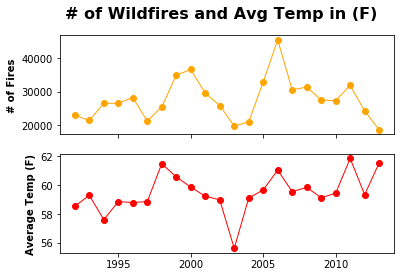

In [78]:

List_year = []
List_fire_count = []
List_temp_avg_f = []



List_year = list(year_sort_count_avg_df['year'])
List_fire_count = list(year_sort_count_avg_df['FIRE_SIZE'])
List_temp_avg_f = list(year_sort_count_avg_df['AverageTemperature_F']) 


fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle("# of Wildfires and Avg Temp in (F)", fontsize=16, fontweight="bold")


x_axis = np.arange(len(List_year))

ax1.plot(List_year, List_fire_count, linewidth=1, marker="o" , color = "orange")
ax1.set_ylabel("# of Fires"  , fontweight = "bold")

ax2.plot(List_year, List_temp_avg_f, linewidth=1, marker="o" , color="red")
ax2.set_ylabel("Average Temp (F)", fontweight = "bold")


tick_locations = [value for value in x_axis]





In [33]:
state_temp_mean_df = final_df.groupby(['state_name','state_abb'])["AverageTemperature_F"].mean()

state_temp_mean_df = state_temp_mean_df.to_frame().reset_index()
state_temp_mean_df.head()


,state_name,state_abb,AverageTemperature_F
0,Alabama,AL,64.120909
1,Arizona,AZ,61.108145
2,Arkansas,AR,61.567573
3,California,CA,59.000180
4,Colorado,CO,46.022077


In [34]:
export_csv = state_temp_mean_df.to_csv (r'Resources\plotly_df.csv', index = None, header=True)

In [35]:
#wildfire_temperature_df["DISCOVERY_DATE"].count()
#for i in range(wildfire_temperature_df["DISCOVERY_DATE"].count()):
#    wildfire_temperature_df["normal_date"] = datetime.utcfromtimestamp(wildfire_temperature_df["DISCOVERY_DATE"][i]).strftime('%Y-%m-%d %H:%M:%S')

#datetime.utcfromtimestamp(wildfire_temperature_df["DISCOVERY_DATE"][6]).strftime('%Y-%m-%d %H:%M:%S')

#print("done")

wildfire_temperature_df['normal_dt'] = pd.to_datetime(wildfire_temperature_df['DISCOVERY_DATE'])
#wildfire_temperature_df['normal_dt'] = pd.to_datetime(wildfire_temperature_df['DISCOVERY_DATE'], unit='ms')

In [36]:
# Get rid of $ and , in the SAL-RATE, then convert it to a float
#def num_to_date(money_str):
    #return datetime.utcfromtimestamp(money_str.strftime('%Y-%m-%d %H:%M:%S')



# Save the result in a new column
#wildfire_temperature_df['Fire_Date'] = wildfire_temperature_df['DISCOVERY_DATE'].apply(num_to_date)
                                
##datetime.utcfromtimestamp(wildfire_temperature_df["DISCOVERY_DATE"][6]).strftime('%Y-%m-%d %H:%M:%S')

In [37]:
#export_csv = wildfire_temperature_df.to_csv (r'Resources\wildfire_temperature_df.csv', index = None, header=True)

#wildfire_temperature_df.head()
###runs successfully but doesn't convert to right date... only shows 1970
wildfire_temperature_df['normal_dt'] = pd.to_datetime(wildfire_temperature_df['DISCOVERY_DATE'])
#wildfire_temperature_df["year"].unique()   

In [38]:
wildfire_temperature_df.head(1)

,FOD_ID,FIRE_NAME,year,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,state_abb,COUNTY,state_name,AverageTemperature,AverageTemperature_F,normal_dt
0,14,TIGER,2004,2453276.5,272,1200.0,4.0,Campfire,6.0,B,38.433333,-120.51,CA,5,California,15.06875,59.12375,1970-01-01 00:00:00.002453276


In [40]:
wildfire_temperature_df['normal_dt'] = pd.to_datetime(wildfire_temperature_df['DISCOVERY_DATE'],unit='s')

In [41]:
wildfire_temperature_df.head()

,FOD_ID,FIRE_NAME,year,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,state_abb,COUNTY,state_name,AverageTemperature,AverageTemperature_F,normal_dt
0,14,TIGER,2004,2453276.5,272,1200.0,4.0,Campfire,6.0,B,38.433333,-120.510000,CA,5,California,15.06875,59.12375,1970-01-29 09:27:56.500
1,17,POWER,2004,2453284.5,280,1415.0,2.0,Equipment Use,16823.0,G,38.523333,-120.211667,CA,5,California,15.06875,59.12375,1970-01-29 09:28:04.500
2,18,FREDS,2004,2453291.5,287,1618.0,2.0,Equipment Use,7700.0,G,38.780000,-120.260000,CA,17,California,15.06875,59.12375,1970-01-29 09:28:11.500
3,165954,ENGEL,2004,2453082.5,78,1414.0,5.0,Debris Burning,2.5,B,40.175278,-120.785556,CA,NaN,California,15.06875,59.12375,1970-01-29 09:24:42.500
4,166325,SHINE,2004,2453111.5,107,1543.0,5.0,Debris Burning,4.0,B,39.400278,-121.103611,CA,NaN,California,15.06875,59.12375,1970-01-29 09:25:11.500


In [42]:
#pd.to_datetime([1349720105, 1349806545, 1349892905, 1349979305, 1350065705], unit='h')

In [43]:
df_year_AverageTemp_F.head()

,year,AverageTemperature_F
0,1992,58.527988
1,1993,59.291739
2,1994,57.602551
3,1995,58.850978
4,1996,58.790539


In [44]:
#wildfire_temperature_fewcol_group_df = wildfire_temperature_fewcol_group_df.reset_index()
wildfire_temperature_fewcol_group_df.head()

,year,state_abb,state_name,FIRE_SIZE,AverageTemperature_F
0,1992,AL,Alabama,1238.0,3634.82810
1,1992,AR,Arkansas,1468.0,5378.78620
2,1992,AZ,Arizona,41916.2,55946.91960
3,1992,CA,California,294114.9,136786.93655
4,1992,CO,Colorado,7248.7,8437.56155


In [45]:
temp_us_group_df.head()

,year,state_name,AverageTemperature,AverageTemperature_F
0,1992,Alabama,17.038583,62.66945
1,1992,Alaska,-5.104333,22.81220
2,1992,Arizona,15.429083,59.77235
3,1992,Arkansas,15.797667,60.43580
4,1992,California,15.276917,59.49845


In [46]:

new_df = pd.merge(wildfire_temperature_fewcol_group_df, temp_us_group_df,   on=['year','state_name'], how='inner')

In [47]:
new_df.head()

,year,state_abb,state_name,FIRE_SIZE,AverageTemperature_F_x,AverageTemperature,AverageTemperature_F_y
0,1992,AL,Alabama,1238.0,3634.82810,17.038583,62.66945
1,1992,AR,Arkansas,1468.0,5378.78620,15.797667,60.43580
2,1992,AZ,Arizona,41916.2,55946.91960,15.429083,59.77235
3,1992,CA,California,294114.9,136786.93655,15.276917,59.49845
4,1992,CO,Colorado,7248.7,8437.56155,7.289250,45.12065


In [48]:
year_sort_count_avg_df.head()

,year,FIRE_SIZE,AverageTemperature_F
0,1992,22964,58.527988
1,1993,21381,59.291739
2,1994,26557,57.602551
3,1995,26530,58.850978
4,1996,28267,58.790539


In [49]:
sortby_num_fire_df = year_count_avg_df.sort_values(by='FIRE_SIZE', ascending=False, na_position='first')
sortby_num_fire_df.head()


,year,FIRE_SIZE,AverageTemperature_F
14,2006,45581,61.042456
8,2000,36701,59.860760
7,1999,34955,60.569590
13,2005,32931,59.665881
19,2011,31954,61.850034


In [50]:

df_year_count_state.head()

,year,FIRE_SIZE
0,1992,22964
1,1993,21381
2,1994,26557
3,1995,26530
4,1996,28267


In [53]:
wildfire_df.head()

,FOD_ID,FIRE_NAME,year,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,state_abb,COUNTY
0,14,TIGER,2004,2453276.5,272,1200.0,4.0,Campfire,6.0,B,38.433333,-120.510000,CA,5
1,17,POWER,2004,2453284.5,280,1415.0,2.0,Equipment Use,16823.0,G,38.523333,-120.211667,CA,5
2,18,FREDS,2004,2453291.5,287,1618.0,2.0,Equipment Use,7700.0,G,38.780000,-120.260000,CA,17
3,25,EAGLE,2004,2453187.5,183,1712.0,1.0,Lightning,2.5,B,33.545278,-105.229444,NM,27
4,26,BACHELOR,2004,2453206.5,202,1405.0,1.0,Lightning,10.0,C,33.315833,-105.512222,NM,27


In [54]:
new_df_2006 = wildfire_df[wildfire_df["year"] == 2006]

In [55]:
new_df_2006.year.count()

49419

In [56]:
df_group_state_firecount = new_df_2006.groupby(['state_abb'])["FIRE_SIZE"].count()

In [58]:
df_group_state_firecount.head()

state_abb
AL    2980
AR    1883
AZ     750
CA    1921
CO     187
Name: FIRE_SIZE, dtype: int64

In [59]:
df_group_state_firecount = df_group_state_firecount.to_frame().reset_index()

In [60]:
df_group_state_firecount.head()

,state_abb,FIRE_SIZE
0,AL,2980
1,AR,1883
2,AZ,750
3,CA,1921
4,CO,187


In [61]:
df_group_state_firecount = df_group_state_firecount.sort_values(by='FIRE_SIZE', ascending=False, na_position='first')

In [65]:
top_10_df = df_group_state_firecount.head(10)
top_10_df

,state_abb,FIRE_SIZE
39,TX,9230
21,MS,4461
7,GA,3838
0,AL,2980
6,FL,2648
32,OK,2241
14,LA,2170
3,CA,1921
30,NY,1884
1,AR,1883


Text(0, 0.5, 'Number of Wildfires')

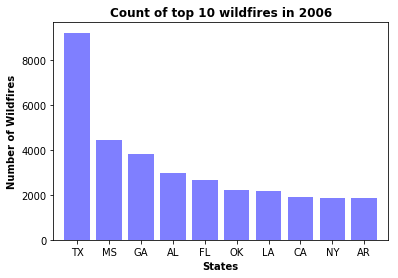

In [75]:
list_fire_count = []
list_fire_count = list(top_10_df['FIRE_SIZE'])
x_axis = np.arange(len(list_fire_count))

list_state_abb = []
list_state_abb = list(top_10_df['state_abb'])

fig, ax = plt.subplots() 

plt.bar(x_axis, list_fire_count, color='blue', alpha=0.5, align="center")

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, list_state_abb)

plt.xlim(-0.75, len(x_axis)-0.25)

plt.title("Count of top 10 wildfires in 2006" , fontweight = "bold")
plt.xlabel("States" , fontweight = "bold")
plt.ylabel("Number of Wildfires" , fontweight = "bold")



In [86]:
temp_df_2006_df = pd.merge(temp_df_2006,states_df, on="state_name" )
temp_df_2006_df.head()

,year,state_name,AverageTemperature,AverageTemperature_F,state_abb
0,2006,Alabama,18.295750,64.93235,AL
1,2006,Alaska,-4.116000,24.59120,AK
2,2006,Arizona,16.220167,61.19630,AZ
3,2006,Arkansas,16.949000,62.50820,AR
4,2006,California,14.945417,58.90175,CA


In [81]:
temp_df_2006 = temp_us_group_df[temp_us_group_df["year"] == 2006]

In [109]:
ttest_desc_FIRE_df = ttest_base_df.sort_values(by='FIRE_SIZE', ascending=False, na_position='first')
ttest_desc_FIRE_df.head(10)

,state_abb,FIRE_SIZE,year,state_name,AverageTemperature,AverageTemperature_F
0,TX,9230,2006,Texas,19.589583,67.26125
1,MS,4461,2006,Mississippi,18.774167,65.79350
2,AL,2980,2006,Alabama,18.295750,64.93235
3,FL,2648,2006,Florida,22.392000,72.30560
4,OK,2241,2006,Oklahoma,17.107750,62.79395
5,LA,2170,2006,Louisiana,20.227833,68.41010
6,CA,1921,2006,California,14.945417,58.90175
7,NY,1884,2006,New York,9.285750,48.71435
8,AR,1883,2006,Arkansas,16.949000,62.50820
9,NC,1558,2006,North Carolina,15.863583,60.55445


Text(0, 0.5, 'Number of Wildfires')

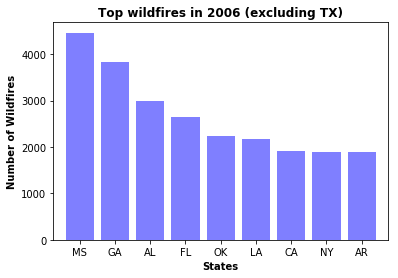

In [97]:
top_9_df = top_10_df[top_10_df["state_abb"] != 'TX']

list_fire_count = []
list_fire_count = list(top_9_df['FIRE_SIZE'])
x_axis = np.arange(len(list_fire_count))

list_state_abb = []
list_state_abb = list(top_9_df['state_abb'])

#####df['net'].plot('o',color = 'orange',linewidth=2.0,use_index = True)

plt.bar(x_axis, list_fire_count, color='blue', alpha=0.5, align="center")

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, list_state_abb)

plt.xlim(-0.75, len(x_axis)-0.25)

plt.title("Top wildfires in 2006 (excluding TX)" , fontweight = "bold")
plt.xlabel("States" , fontweight = "bold")
plt.ylabel("Number of Wildfires" , fontweight = "bold")


In [105]:
#year_count_avg_df = pd.merge(df_year_count_state, df_year_AverageTemp_F,   on=['year'], how='inner')

#this df has state_abb and count of fires for the year 2006 - total count is 47 states
#df_group_state_firecount.head()


# this df has 48 states temp with state_name and state_abb
temp_df_2006_df.head(100)


ttest_base_df = pd.merge(df_group_state_firecount, temp_df_2006_df,   on=['state_abb'], how='inner')

In [110]:
#ttest_base_df

ttest_desc_temp_df = ttest_base_df.sort_values(by='AverageTemperature_F', ascending=False, na_position='first')
ttest_high_temp_df = ttest_desc_temp_df.head(20)



,state_abb,FIRE_SIZE,year,state_name,AverageTemperature,AverageTemperature_F
3,FL,2648,2006,Florida,22.392000,72.30560
5,LA,2170,2006,Louisiana,20.227833,68.41010
0,TX,9230,2006,Texas,19.589583,67.26125
1,MS,4461,2006,Mississippi,18.774167,65.79350
2,AL,2980,2006,Alabama,18.295750,64.93235
10,SC,1541,2006,South Carolina,18.011667,64.42100
4,OK,2241,2006,Oklahoma,17.107750,62.79395
8,AR,1883,2006,Arkansas,16.949000,62.50820
15,AZ,750,2006,Arizona,16.220167,61.19630
9,NC,1558,2006,North Carolina,15.863583,60.55445


In [112]:
ttest_asc_temp_df = ttest_base_df.sort_values(by='AverageTemperature_F', ascending=True, na_position='first')
ttest_low_temp_df = ttest_asc_temp_df.head(20)
ttest_low_temp_df

,state_abb,FIRE_SIZE,year,state_name,AverageTemperature,AverageTemperature_F
29,WY,244,2006,Wyoming,6.427583,43.56965
17,ID,586,2006,Idaho,6.432250,43.57805
34,ME,149,2006,Maine,6.803000,44.24540
19,MT,578,2006,Montana,6.911417,44.44055
24,ND,381,2006,North Dakota,6.914167,44.44550
14,MN,852,2006,Minnesota,7.095833,44.77250
45,VT,1,2006,Vermont,7.682750,45.82895
40,NH,36,2006,New Hampshire,7.893750,46.20875
32,CO,187,2006,Colorado,7.973500,46.35230
27,WI,293,2006,Wisconsin,8.152083,46.67375


In [113]:
list_high_temp = []
list_high_temp = list(ttest_high_temp_df['AverageTemperature_F'])

list_low_temp = []
list_low_temp = list(ttest_low_temp_df['AverageTemperature_F'])


#high_prices = [randint(1, 5) * 1000 for x in range(1, 10)]
high_means = np.mean(list_high_temp)
high_sem = sem(list_high_temp)

#low_prices = [randint(1, 5) * 200 for x in range(1, 10)]
low_means = np.mean(list_low_temp)
low_sem = sem(list_low_temp)

means = [high_means, low_means]
sems = [high_sem, low_sem]
labels = ["High Temperatures", "Low Temperatures"]

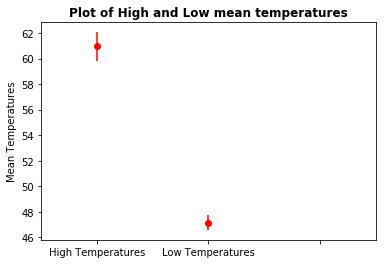

In [125]:
# Plot
fig, ax = plt.subplots()

ax.errorbar(np.arange(0, len(means)), means, yerr=sems, fmt="o", color='red')

ax.set_xlim(-0.5, 2.5)
ax.set_xticklabels(labels)
ax.set_xticks([0, 1, 2])

ax.set_ylabel("Mean Temperatures")

plt.title("Plot of High and Low mean temperatures" , fontweight = "bold", color="black")

plt.show()

In [115]:
# t-test
(t_stat, p) = ttest_ind(list_high_temp, list_low_temp, equal_var=False)

if p < 0.05:
    print("The differences between the high and low temperatures are significant.")
else:
    print("The differences between high and low temperatures are due to chance.")

The differences between the high and low temperatures are significant.


In [116]:
print(p)

9.677722129065092e-12


In [128]:
asc_firesize_df = ttest_base_df.sort_values(by='FIRE_SIZE', ascending=True, na_position='first')
top10_asc_firesize_df = asc_firesize_df.head(10)
top10_asc_firesize_df

,state_abb,FIRE_SIZE,year,state_name,AverageTemperature,AverageTemperature_F
45,VT,1,2006,Vermont,7.682750,45.82895
44,MA,3,2006,Massachusetts,9.739083,49.53035
43,RI,11,2006,Rhode Island,10.989167,51.78050
42,IN,15,2006,Indiana,12.418750,54.35375
41,IL,17,2006,Illinois,12.576833,54.63830
40,NH,36,2006,New Hampshire,7.893750,46.20875
39,CT,48,2006,Connecticut,11.025417,51.84575
38,NE,72,2006,Nebraska,10.915417,51.64775
37,OH,74,2006,Ohio,11.903167,53.42570
36,NJ,117,2006,New Jersey,12.519917,54.53585


Text(0, 0.5, 'Number of Wildfires')

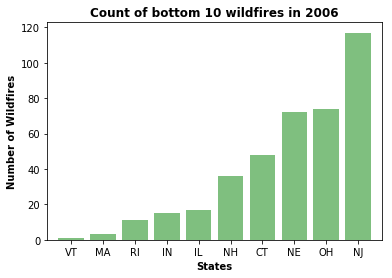

In [129]:
list_fire_count = []
list_fire_count = list(top10_asc_firesize_df['FIRE_SIZE'])
x_axis = np.arange(len(list_fire_count))

list_state_abb = []
list_state_abb = list(top10_asc_firesize_df['state_abb'])

fig, ax = plt.subplots() 

plt.bar(x_axis, list_fire_count, color='green', alpha=0.5, align="center")

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, list_state_abb)

plt.xlim(-0.75, len(x_axis)-0.25)

plt.title("Count of bottom 10 wildfires in 2006" , fontweight = "bold")
plt.xlabel("States" , fontweight = "bold")
plt.ylabel("Number of Wildfires" , fontweight = "bold")